Measure delay for phase vs. frequency calibration.

In [1]:
import sys
sys.path.append('../../qick/qick_lib/')
sys.path.append('../soft/')
import Scan
from mkids import *
import matplotlib.pyplot as plt


In [2]:
board = Scan.getBoard()
if board == 'zcu111':
    bitfile = 'mkids_2x2_kidsim_v1'    
elif board == 'zcu216':
    bitfile = 'mkids_2x2_kidsim_v2'
elif board == 'rfsoc4x2':
    bitfile = 'mkids_v3'
else:
    raise Exception("Do not know what to do with %s"%board)
scan = Scan.Scan(bitfile)

In [3]:
fMixerSimu = 512
fMixerKids = scan.fNyquist/2

In [4]:
# Initialize simulation chain with no resonance
simu = scan.simuChain
simu.analysis.qout(3)
simu.synthesis.qout(3)
simu.alloff()
simu.set_mixer_frequency(fMixerSimu)


In [5]:
# Initialize the kids chain
kids = scan.kidsChain
kids.analysis.qout(2)
kids.synthesis.qout(2)
kids.set_mixer_frequency(fMixerKids)

  0%|          | 0/50 [00:00<?, ?it/s]

fTone = 1804.8


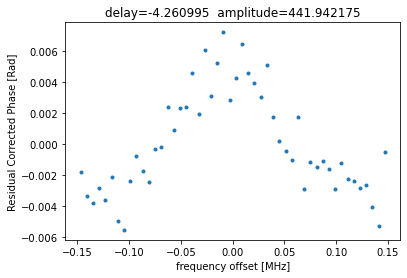

In [6]:
def getDelayForOutCh(outCh, df=None, N=50, doProgress=False, plotFit=False, fMixer=700):
    scan.set_mixer(fMixer)
    kids = scan.kidsChain
    qFMixer = scan.get_mixer()
    pfbFs = kids.synthesis.dict['chain']['fs']
    fMinimum = qFMixer-pfbFs/2
    fMaximum = qFMixer+pfbFs/2

    fTone = scan.outCh2Freq(outCh)
    if df is None:
        df = kids.synthesis.fc_ch
    fMin = np.maximum(fMinimum, fTone-df/2)
    fMax = np.minimum(fMaximum, fTone+df/2)
    df = fMax-fMin
    fc = (fMin+fMax)/2
    freqs = np.array([fc])
    fis = np.zeros(1)
    gs = 0.9*np.ones(1)
    kids.set_tones(freqs, fis, gs)
    fOffsets = kids.get_sweep_offsets(df, N)
    xs = kids.sweep_tones(df, N, mean=True, doProgress=doProgress)
    delay,phi0 = measureDelay(fOffsets, xs[:,0], plotFit=plotFit) 
    return delay,xs,fOffsets,fTone,phi0
delay,xs,fOffsets,fTone,phi0 = getDelayForOutCh(30, df=0.3, N=50, doProgress=True, plotFit=True, fMixer=fMixerKids)
print("fTone =",fTone)

In [7]:
delays = np.zeros(scan.nOutCh)
phi0s = np.zeros(scan.nOutCh)
amps = np.zeros(scan.nOutCh)
freqs = np.zeros(scan.nOutCh)
allXs = []
df = kids.synthesis.fc_ch
N = 500
for i in range(scan.nOutCh):
    delay,xs,fOffsets,f0,phi0 = getDelayForOutCh(i, df, N, fMixer=fMixerKids)
    delays[i] = delay
    phi0s[i] = phi0
    amps[i] = np.mean(np.abs(xs))
    freqs[i] = f0
    allXs.append(xs)
    print(i,f0,delay,amps[i])

0 1228.8 -4.261365994863562 1100.8491574128018
1 1248.0 -4.261526774976657 1080.9249624305164
2 1267.2 -4.261619781268376 1104.020640929834
3 1286.3999999999999 -4.2617474803136135 1140.0738808765948
4 1305.6 -4.2618889679314576 1184.9710118834628
5 1324.8 -4.262026280362304 1226.9101984725544
6 1344.0 -4.262130409483529 1258.2003824709943
7 1363.2 -4.262181024020297 1274.4201741706922
8 1382.3999999999999 -4.262197020129474 1271.256281587885
9 1401.6 -4.2621467096498975 1247.6759995091315
10 1420.8 -4.2620480322108465 1206.582335785991
11 1440.0 -4.261900875002188 1157.8574679117924
12 1459.1999999999998 -4.261777028688159 1109.2349285649445
13 1478.3999999999999 -4.2616768245778545 1070.9021526324254
14 1497.6 -4.261622535790825 1043.9329928186648
15 1516.8 -4.261606018523332 1030.4727751540568
16 1536.0 -4.261636009611433 1030.5528898756486
17 1555.1999999999998 -4.261702491759068 1041.8113726591994
18 1574.3999999999999 -4.261795695885406 1063.3272442621194
19 1593.6 -4.26189319413

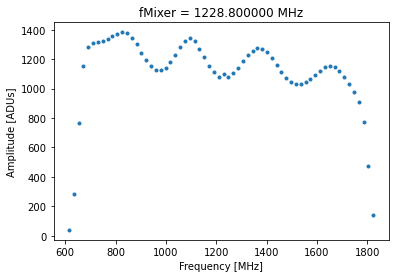

In [8]:
plt.plot(freqs, amps, '.')
plt.xlabel("Frequency [MHz]")
plt.ylabel("Amplitude [ADUs]")
__ = plt.title("fMixer = %f MHz"%fMixerKids)

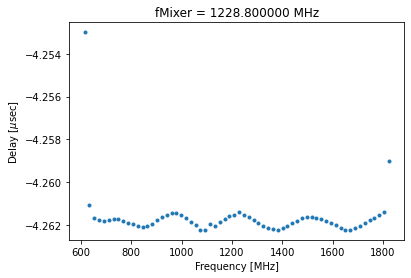

In [9]:
plt.plot(freqs, delays, '.')
plt.xlabel("Frequency [MHz]")
plt.ylabel("Delay [$\mu$sec]")
__ = plt.title("fMixer = %f MHz"%fMixerKids)

In [10]:
outCh = 10
fCenter = scan.outCh2Freq(outCh)
print(fCenter)

fResonance = fCenter + 0.123
simu.alloff()
simu.enable(fResonance)
freqs = np.array([fCenter])
fis = np.zeros(1)
gs = 0.9*np.ones(1)
kids.set_tones(freqs, fis, gs)
df=1.7
N=200
fOffsets = kids.get_sweep_offsets(df, N)
doProgress = True
xs = kids.sweep_tones(df, N, mean=True, doProgress=doProgress)

1420.8


  0%|          | 0/200 [00:00<?, ?it/s]

In [11]:
delayMean = delays.mean()
print(delayMean)
xsd = applyDelay(freqs, fOffsets, xs, delayMean)

-4.2616295935969575


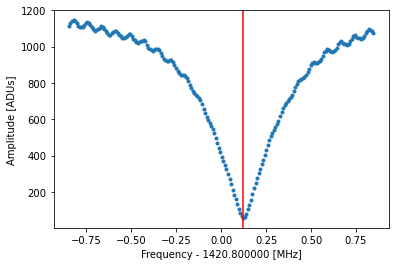

In [12]:
plt.plot(fOffsets, np.abs(xsd), '.')
plt.xlabel("Frequency - %f [MHz]"%freqs[0])
plt.ylabel("Amplitude [ADUs]")
plt.axvline(fResonance-freqs[0], c='r')

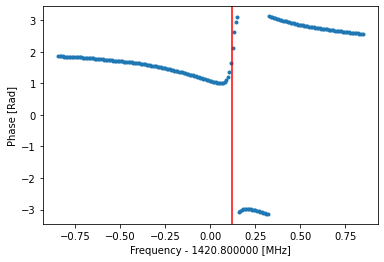

In [13]:
plt.plot(fOffsets, np.angle(xsd), '.')
plt.xlabel("Frequency - %f [MHz]"%freqs[0])
plt.ylabel("Phase [Rad]")
plt.axvline(fResonance-freqs[0], c='r')

Text(0, 0.5, 'Q [ADUs]')

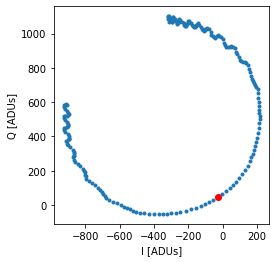

In [14]:
plt.plot(np.real(xsd),np.imag(xsd),'.')
ind = np.searchsorted(fOffsets,fResonance-freqs[0])
plt.plot(np.real(xsd[ind]), np.imag(xsd[ind]), 'ro')
plt.gca().set_aspect('equal')
plt.xlabel("I [ADUs]")
plt.ylabel("Q [ADUs]")

fc = 19.2


  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 0, 'Offset Frequency from 1420.8 MHz')

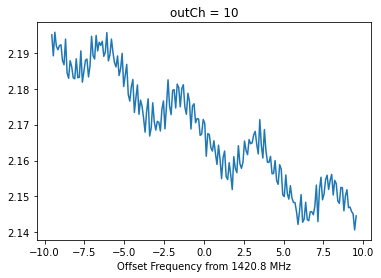

In [17]:
simu.alloff()
f0 = scan.outCh2Freq(outCh)
fc = kids.synthesis.fc_ch
print("fc =",fc)
fCenter = f0
freqs = np.array([fCenter])
fis = np.zeros(1)
gs = 0.9*np.ones(1)
kids.set_tones(freqs, fis, gs)
df=fc
N=200
fOffsets = kids.get_sweep_offsets(df, N)
doProgress = True
xs = kids.sweep_tones(df, N, mean=True, doProgress=doProgress)
xsd = applyDelay(freqs, fOffsets, xs, delayMean)
plt.plot(fOffsets, np.angle(xsd))
plt.title("outCh = %d"%outCh)
plt.xlabel("Offset Frequency from %.1f MHz"%f0)
plt.ylabel("Phase [Rad]")
plt.title("no resonator")

fc = 19.2


  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'no resonator')

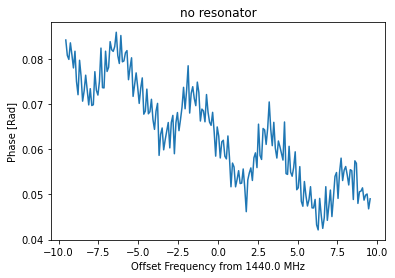

In [19]:
simu.alloff()
f0 = scan.outCh2Freq(outCh+1)
fc = kids.synthesis.fc_ch
print("fc =",fc)
fCenter = f0
freqs = np.array([fCenter])
fis = np.zeros(1)
gs = 0.9*np.ones(1)
kids.set_tones(freqs, fis, gs)
df=fc
N=200
fOffsets = kids.get_sweep_offsets(df, N)
doProgress = True
xs = kids.sweep_tones(df, N, mean=True, doProgress=doProgress)
xsd = applyDelay(freqs, fOffsets, xs, delayMean)
plt.plot(fOffsets, np.angle(xsd))
plt.title("outCh = %d"%(outCh+1))
plt.xlabel("Offset Frequency from %.1f MHz"%f0)
plt.ylabel("Phase [Rad]")
plt.title("no resonator")

In [20]:
simu.alloff()
f0 = scan.outCh2Freq(outCh)
fc = kids.synthesis.fc_ch
fCenter = f0 + fc/2
freqs = np.array([fCenter])
fis = np.zeros(1)
gs = 0.9*np.ones(1)
kids.set_tones(freqs, fis, gs)
df=1.9*fc
N=200
fOffsets = kids.get_sweep_offsets(df, N)
doProgress = True
xs = kids.sweep_tones(df, N, mean=True, doProgress=doProgress)

  0%|          | 0/200 [00:00<?, ?it/s]

In [21]:
outChs = np.unique(scan.outFreq2ch(freqs+fOffsets))

In [22]:
xsd = applyDelay(freqs, fOffsets, xs, delayMean)

Text(0.5, 1.0, 'delta phase = -2.104 between outCh=10,11')

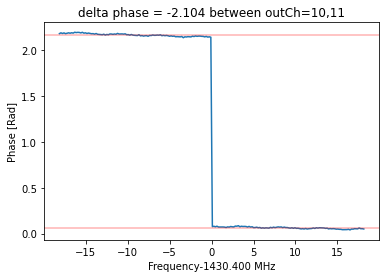

In [23]:
plt.plot(fOffsets, np.angle(xsd))
phi = np.angle(xsd)
phi0 = np.mean(phi[fOffsets<0])
phi1 = np.mean(phi[fOffsets>0])
plt.axhline(phi0, c='r', alpha=0.3)
plt.axhline(phi1, c='r', alpha=0.3)
deltaPhi = phi1-phi0
plt.xlabel("Frequency-%.3f MHz"%freqs[0])
plt.ylabel("Phase [Rad]")
plt.title("delta phase = %.3f between outCh=%d,%d"%(deltaPhi,outChs[0],outChs[1]))